# 02750 HW4
## Anushka Sinha (anushka3)

## Exercise 2 Proactive Learning

#### Imports

In [38]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import warnings
import random
from sklearn.preprocessing import LabelEncoder
import tqdm
from sklearn.cluster import KMeans
from tqdm import tqdm
from itertools import zip_longest


#### Data

In [39]:
data = pd.read_csv("hw4_ex2_data.csv")
data_array = data.to_numpy()
shuffled_data = shuffle(data, random_state=42)


In [40]:
random_seeds = []
for i in range(10):
    random.seed(97*i)
    random_seeds.append(random.randint(1, 100))
random_seeds

[50, 25, 78, 85, 48, 18, 27, 84, 58, 19]

## Method 3: Variable Cost Oracle

In [41]:
def get_entropies(labels_probs):
    entropies = [] 
    epsilon = 0.0001
    for i in labels_probs:
        prod = i * np.log2(i+epsilon)
        entropies.append(-np.sum(prod))
    return entropies
        

In [42]:
def proactive_learning(d_array, seed):
    test_acc = []
    d_array = shuffle(d_array, random_state=seed)
    max_budget = 500
    
    # Start with five (5) random observations 
    test_size_fraction = 1- (5 / len(d_array)) 
    sample_data, remaining_data = train_test_split(d_array, test_size=test_size_fraction, random_state=seed)
    sample_data_X, sample_data_y = sample_data[:, :-3], sample_data[:, -3]
    remaining_data_X, remaining_data_y = remaining_data[:, :-3], remaining_data[:, -3]
    costs = remaining_data[:, -2]
    current_spending = 0
    spending_history = [0]
    
    # Run the loop until the sample data includes 50% of the original data 
    while current_spending < max_budget:

        # Training a model on the current sample data
        mod = RandomForestClassifier(random_state=None)
        mod.fit(sample_data_X, sample_data_y)
        # Predict on unseen data 
        y_pred = mod.predict(remaining_data_X)
        test_accuracy = accuracy_score(remaining_data_y, y_pred)
        test_acc.append(test_accuracy) 
        
        # Predicting class probabilities for the remaining data
        labels_probabilities = np.array(mod.predict_proba(remaining_data_X)) 

        # Calculating and normalizing entropies
        entropies = get_entropies(labels_probabilities)
        max_entropy = np.max(entropies)
        normalized_entropies = entropies/max_entropy
        
        # Calculating utility 
        max_cost = np.max(costs)
        normalized_costs = costs/max_cost
        utilities = normalized_entropies - normalized_costs
        
        # Selecting the instance with highest utility 
        highest_utility_ind = np.argmax(utilities)
        current_spending += costs[highest_utility_ind]
        spending_history.append(current_spending)
        # Get the data of the instance to add
        instance_X, instance_y = remaining_data_X[highest_utility_ind], remaining_data_y[highest_utility_ind]
       
        # Add the queried instance to the training set
        sample_data_X = np.append(sample_data_X, [instance_X], axis=0)
        sample_data_y = np.append(sample_data_y, [instance_y], axis=0)
        
        # Remove the queried instance from the pool and costs 
        remaining_data = np.delete(remaining_data, highest_utility_ind, axis=0)
        remaining_data_X, remaining_data_y = remaining_data[:, :-3], remaining_data[:, -3]
        remaining_indices = list(range(len(remaining_data_X)))
        costs = np.delete(costs, highest_utility_ind)
        
    return  test_acc, spending_history


In [43]:
# Running Proactive Learning - method 3
method_3_acc = dict() 
method_3_spending = dict()

for seed in tqdm(random_seeds):
    test_accur, spending = proactive_learning(data_array, seed)
    method_3_acc[seed] = test_accur 
    method_3_spending[seed] = spending

all_accs_method_3 = list(method_3_acc.values())
all_spendings_method_3 = list(method_3_spending.values())



100%|██████████| 10/10 [01:01<00:00,  6.12s/it]


In [44]:
for sublist in all_spendings_method_3:
    if len(sublist) > max_length:
        max_length = len(sublist)

same_length_acc_method_3 = []
for acc in all_accs_method_3:
    same_length_acc_method_3.append(np.pad(acc, (0, max_length - len(acc)), 'constant', constant_values=np.nan))

same_length_spendings_method_3 = []
for spend in all_spendings_method_3:
    same_length_spendings_method_3.append(np.pad(spend, (0, max_length - len(spend)), 'constant', constant_values=np.nan))


avg_acc_method_3 = np.nanmean(same_length_acc_method_3, axis=0)
std_acc_method_3 = np.nanstd(same_length_acc_method_3, axis=0)
avg_spendings_method_3 = np.nanmean(same_length_spendings_method_3, axis=0)
std_spending_method_3 = np.nanstd(same_length_spendings_method_3, axis=0)


/var/folders/c_/t9gykjb919v3fc912l8ql86h0000gn/T/ipykernel_10967/2723172454.py:14: RuntimeWarning: Mean of empty slice
  avg_acc_method_3 = np.nanmean(same_length_acc_method_3, axis=0)
/Users/sinhanushka_/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/c_/t9gykjb919v3fc912l8ql86h0000gn/T/ipykernel_10967/2723172454.py:16: RuntimeWarning: Mean of empty slice
  avg_spendings_method_3 = np.nanmean(same_length_spendings_method_3, axis=0)


##  Method 1: Choose The Least Costly Instance for Observation

In [45]:
def choose_least_costly_instance(d_array, seed):
    test_acc = []
    indices = np.arange(d_array.shape[0])  
    max_budget = 500
    test_size_fraction = 1 - (5 / len(d_array))
    sample_data, remaining_data, sample_indices, remaining_indices = train_test_split(
        d_array, indices, test_size=test_size_fraction, random_state=seed)

    sample_data_X, sample_data_y = sample_data[:, :-3], sample_data[:, -3]
    remaining_data_X, remaining_data_y = remaining_data[:, :-3], remaining_data[:, -3]
    costs = remaining_data[:, -2]
    current_spending = 0
    spending_history = [0]
    # Run the loop until the sample data includes 50% of the original data 
    while current_spending < max_budget:

        # Training a model on the current sample data
        mod = RandomForestClassifier(random_state=None)
        mod.fit(sample_data_X, sample_data_y)
        # Predict on unseen data 
        y_pred = mod.predict(remaining_data_X)
        test_accuracy = accuracy_score(remaining_data_y, y_pred)
        test_acc.append(test_accuracy) 
        
        # Get indices of samples with least cost
        least_costly_instances = np.min(costs)
        min_indices = np.where(costs == least_costly_instances)[0]
        random_min_index = np.random.choice(min_indices)
        current_spending += costs[random_min_index]
        spending_history.append(current_spending)
        # Get the data of the instance to add
        instance_X, instance_y = remaining_data_X[random_min_index], remaining_data_y[random_min_index]
       
        # Add the queried instance to the training set
        sample_data_X = np.append(sample_data_X, [instance_X], axis=0)
        sample_data_y = np.append(sample_data_y, [instance_y], axis=0)
        
        # Remove the queried instance from the pool and costs 
        remaining_data = np.delete(remaining_data, random_min_index, axis=0)
        remaining_data_X, remaining_data_y = remaining_data[:, :-3], remaining_data[:, -3]
        remaining_indices = list(range(len(remaining_data_X)))
        costs = np.delete(costs, random_min_index)
        
    return  test_acc, spending_history


In [46]:
# Running Method 1
method_1_acc = dict() 
method_1_spending = dict()

for seed in tqdm(random_seeds):
    test_accur, spending = choose_least_costly_instance(data_array, seed)
    method_1_acc[seed] = test_accur 
    method_1_spending[seed] = spending

all_accs_method_1 = list(method_1_acc.values())
all_spendings_method_1 = list(method_1_spending.values())

100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


In [47]:
for sublist in all_spendings_method_1:
    if len(sublist) > max_length:
        max_length = len(sublist)

same_length_acc_method_1 = []
for acc in all_accs_method_1:
    same_length_acc_method_1.append(np.pad(acc, (0, max_length - len(acc)), 'constant', constant_values=np.nan))

same_length_spendings_method_1 = []
for spend in all_spendings_method_1:
    same_length_spendings_method_1.append(np.pad(spend, (0, max_length - len(spend)), 'constant', constant_values=np.nan))


avg_acc_method_1 = np.nanmean(same_length_acc_method_1, axis=0)
std_acc_method_1 = np.nanstd(same_length_acc_method_1, axis=0)
avg_spendings_method_1 = np.nanmean(same_length_spendings_method_1, axis=0)
std_spending_method_1 = np.nanstd(same_length_spendings_method_1, axis=0)


/var/folders/c_/t9gykjb919v3fc912l8ql86h0000gn/T/ipykernel_10967/1437430746.py:14: RuntimeWarning: Mean of empty slice
  avg_acc_method_1 = np.nanmean(same_length_acc_method_1, axis=0)
/Users/sinhanushka_/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


## Method 2: Randomly Select an Instance

In [48]:
def choose_random(d_array, seed):
    test_acc = []
    d_array = shuffle(d_array, random_state=seed) 
    max_budget = 500
    test_size_fraction = 1 - (5 / len(d_array))
    sample_data, remaining_data = train_test_split(d_array, test_size=test_size_fraction, random_state=seed)
    sample_data_X, sample_data_y = sample_data[:, :-3], sample_data[:, -3]
    remaining_data_X, remaining_data_y = remaining_data[:, :-3], remaining_data[:, -3]
    costs = remaining_data[:, -2]
    current_spending = 0
    spending_history = [0]

    # Run the loop until the sample data includes 50% of the original data 
    while current_spending < max_budget:

        # Training a model on the current sample data
        mod = RandomForestClassifier(random_state=None)
        mod.fit(sample_data_X, sample_data_y)
        # Predict on unseen data 
        y_pred = mod.predict(remaining_data_X)
        test_accuracy = accuracy_score(remaining_data_y, y_pred)
        test_acc.append(test_accuracy) 

        # Randomly choose an index from remaining_data_X
        random_index = np.random.randint(len(remaining_data_X))  
        current_spending += costs[random_index]
        spending_history.append(current_spending)
        
        # Get the data of the instance to add
        instance_X, instance_y = remaining_data_X[random_index], remaining_data_y[random_index]
       
        # Add the queried instance to the training set
        sample_data_X = np.append(sample_data_X, [instance_X], axis=0)
        sample_data_y = np.append(sample_data_y, [instance_y], axis=0)
        
        # Remove the queried instance from the pool
        remaining_data_X = np.delete(remaining_data_X, random_index, axis=0)
        remaining_data_y = np.delete(remaining_data_y, random_index, axis=0)
        costs = np.delete(costs, random_index)
        
    return test_acc, spending_history


In [49]:
# Running Method 2
method_2_acc = dict() 
method_2_spending = dict()

for seed in tqdm(random_seeds):
    test_accur, spending = choose_random(data_array, seed)
    method_2_acc[seed] = test_accur 
    method_2_spending[seed] = spending

all_accs_method_2 = list(method_2_acc.values())
all_spendings_method_2 = list(method_2_spending.values())

100%|██████████| 10/10 [00:31<00:00,  3.17s/it]


In [50]:
for sublist in all_spendings_method_2:
    if len(sublist) > max_length:
        max_length = len(sublist)

same_length_acc_method_2 = []
for acc in all_accs_method_2:
    same_length_acc_method_2.append(np.pad(acc, (0, max_length - len(acc)), 'constant', constant_values=np.nan))

same_length_spendings_method_2 = []
for spend in all_spendings_method_2:
    same_length_spendings_method_2.append(np.pad(spend, (0, max_length - len(spend)), 'constant', constant_values=np.nan))


avg_acc_method_2 = np.nanmean(same_length_acc_method_2, axis=0)
std_acc_method_2 = np.nanstd(same_length_acc_method_2, axis=0)
avg_spendings_method_2 = np.nanmean(same_length_spendings_method_2, axis=0)
std_spending_method_2 = np.nanstd(same_length_spendings_method_2, axis=0)


/var/folders/c_/t9gykjb919v3fc912l8ql86h0000gn/T/ipykernel_10967/3351773164.py:14: RuntimeWarning: Mean of empty slice
  avg_acc_method_2 = np.nanmean(same_length_acc_method_2, axis=0)
/Users/sinhanushka_/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/c_/t9gykjb919v3fc912l8ql86h0000gn/T/ipykernel_10967/3351773164.py:16: RuntimeWarning: Mean of empty slice
  avg_spendings_method_2 = np.nanmean(same_length_spendings_method_2, axis=0)


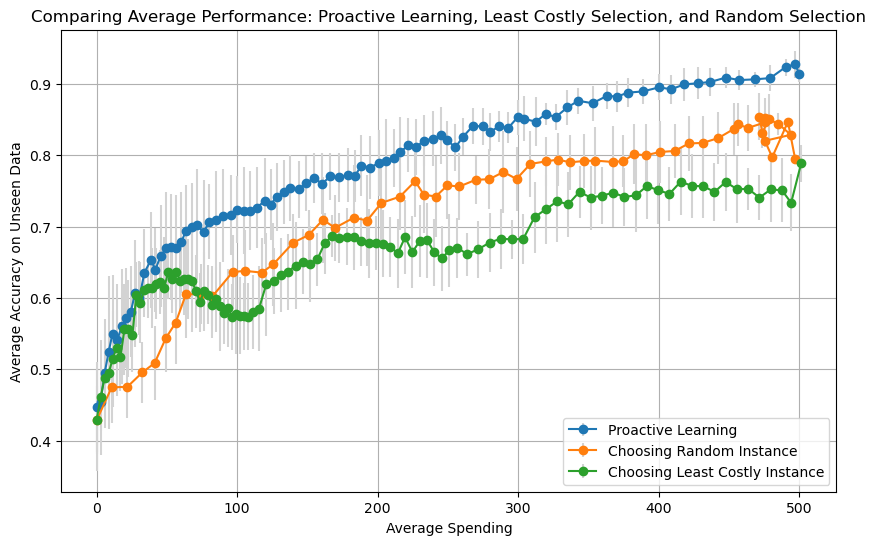

In [51]:
plt.figure(figsize=(10, 6))
plt.errorbar(avg_spendings_method_3, avg_acc_method_3, yerr=std_acc_method_3, fmt='-o', label='Proactive Learning', ecolor='lightgray')
plt.errorbar(avg_spendings_method_2, avg_acc_method_2, yerr=std_acc_method_2, fmt='-o', label='Choosing Random Instance', ecolor='lightgray')
plt.errorbar(avg_spendings_method_1, avg_acc_method_1, yerr=std_acc_method_1, fmt='-o', label='Choosing Least Costly Instance', ecolor='lightgray')

plt.xlabel('Average Spending')
plt.ylabel('Average Accuracy on Unseen Data')
plt.title('Comparing Average Performance: Proactive Learning, Least Costly Selection, and Random Selection')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()